<a href="https://colab.research.google.com/github/tejaswi1995prakash/HDFC-Bank-Strategy-using-Machine-Learning/blob/main/HDFC_ML_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Problem Statement**
Create a Machine Learning Strategy to predict the future returns of HDFC Bank

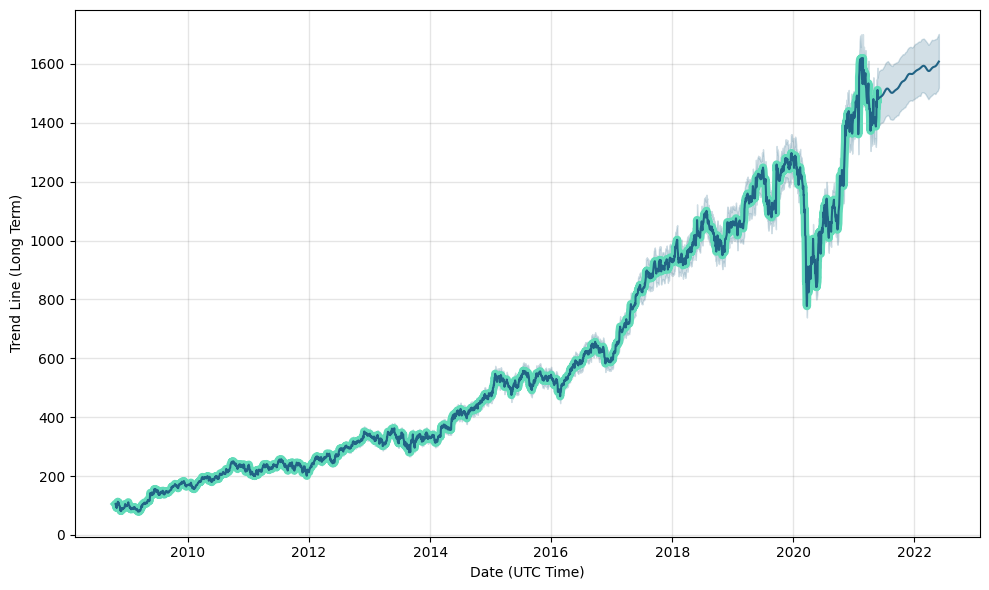

# Importing libraries

In [712]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
from datetime import datetime
from pandas import Timestamp
from statistics import mean
from datetime import timedelta  
import math
import calendar
import plotly.graph_objects as go
from pandas_datareader import data as web
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, KFold, cross_val_score

Reading the data from the DataReader Module


> 2000-01-01 to 2021-05-01



In [713]:
df = web.DataReader('HDFCBANK.NS',data_source='yahoo' ,start='2000-01-01',end='2021-05-01')
df=df[['Open','High','Low','Close','Volume']]
df = df.reset_index()

Displaying the header

In [714]:
df.head()

,Date,Open,High,Low,Close,Volume
0,2000-01-03,16.600000,17.000000,16.600000,17.000000,332590.0
1,2000-01-04,18.200001,18.344999,17.100000,17.379999,1687100.0
2,2000-01-05,17.000000,17.389999,16.500000,16.695000,1598200.0
3,2000-01-06,16.799999,17.000000,16.530001,16.830000,850260.0
4,2000-01-07,16.215000,17.100000,16.215000,16.834999,851440.0


First off, let us check if there are missing values in the data

In [715]:
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

We have no missing values in our data set

## CALCULATING VOLATILITY

TO Calculate Volatility we use the **ATR** indicator 


ATR is calculated by


1.   First Calculating True Range 
2.   Then calculating Exponential Moving Average of True Range over a desired period



Calculating TrueRange

In [716]:
def TR(d,c,h,l,o,yc):
  x = h - l
  y = abs(h-yc)
  z = abs(l-yc)
  
  if y <= x >= z:
    TR = x
  elif x <= y >=z:
    TR = y
  elif x <= z >=y:
    TR = z

  return (d,TR)

In [717]:
a = 1
TR_Dates = []
True_Ranges = []

while a < len(df['Date']):
  TRDate, TrueRange = TR(df['Date'][a], df['Close'][a], df['High'][a], df['Low'][a],df['Open'][a], df['Close'][a-1])
  TR_Dates.append(TRDate)
  True_Ranges.append(round(TrueRange,1))
  a = a+1


Defining Exponential Moving Average

In [718]:
def ExpMovingAverage(values, period):
  weights = np.exp(np.linspace(-1.,0.,period))
  weights /= weights.sum()

  a = np.convolve(values, weights)[:len(values)]
  a[:period] = a[period]
  return a

Now we calculate **ATR** by calculating **EMA** of **TrueRange**

In [719]:
ATR = ExpMovingAverage(True_Ranges,14)

Printing the ATR of the top 5 quantities

In [720]:
ATR[:5]

array([0.99143935, 0.99143935, 0.99143935, 0.99143935, 0.99143935])

Now we create a dataframe for volatility called df_vol

In [721]:
df_vol = pd.DataFrame(TR_Dates,columns=['Date'])

In [722]:
df_vol['ATR'] = ATR

The length of df_vol will be one short of the original dataframe **df** since we calculate the difference between today's close and yesterday's close in *TrueRange*

In [723]:
df_vol.head()

,Date,ATR
0,2000-01-04,0.991439
1,2000-01-05,0.991439
2,2000-01-06,0.991439
3,2000-01-07,0.991439
4,2000-01-10,0.991439


Now we merge the original dataframe **df** and the volatility dataframe **vol_df** through inner join on **Date**

In [724]:
newdf = pd.merge(df,df_vol)

In [725]:
newdf.head()

,Date,Open,High,Low,Close,Volume,ATR
0,2000-01-04,18.200001,18.344999,17.100000,17.379999,1687100.0,0.991439
1,2000-01-05,17.000000,17.389999,16.500000,16.695000,1598200.0,0.991439
2,2000-01-06,16.799999,17.000000,16.530001,16.830000,850260.0,0.991439
3,2000-01-07,16.215000,17.100000,16.215000,16.834999,851440.0,0.991439
4,2000-01-10,17.290001,17.950001,16.500000,16.590000,1004340.0,0.991439


## Calculating RSI

In [726]:
cl = df['Close']
delta = cl.diff()
delta = delta[1:]

In [727]:
period = 14
up, down = delta.clip(lower=0), delta.clip(upper=0)
roll_up1 = up.ewm(span= period).mean()
roll_down1 = down.abs().ewm(span= period).mean()

RS1 = roll_up1 / roll_down1
RSI1 = 100.0 - (100.0 / (1.0 + RS1))

In [728]:
RSI1

1       100.000000
2        32.467928
3        41.458119
4        41.789229
5        31.662553
           ...    
5320     41.684352
5321     53.808892
5322     63.618228
5323     61.906201
5324     43.148929
Name: Close, Length: 5324, dtype: float64

In [729]:
df_RSI = pd.DataFrame(df['Date'][1:])

Creating a dataframe for **RSI** called **df_RSI**

In [730]:
df_RSI['RSI'] = RSI1

In [731]:
df_RSI

,Date,RSI
1,2000-01-04,100.000000
2,2000-01-05,32.467928
3,2000-01-06,41.458119
4,2000-01-07,41.789229
5,2000-01-10,31.662553
...,...,...
5320,2021-04-26,41.684352
5321,2021-04-27,53.808892
5322,2021-04-28,63.618228
5323,2021-04-29,61.906201


Now we here again merge the dataframe **newdf** and the RSI dataframe **df_RSI** through inner join on **Date**

In [732]:
newdf = pd.merge(newdf,df_RSI,on='Date')

In [733]:
newdf.head()

,Date,Open,High,Low,Close,Volume,ATR,RSI
0,2000-01-04,18.200001,18.344999,17.100000,17.379999,1687100.0,0.991439,100.000000
1,2000-01-05,17.000000,17.389999,16.500000,16.695000,1598200.0,0.991439,32.467928
2,2000-01-06,16.799999,17.000000,16.530001,16.830000,850260.0,0.991439,41.458119
3,2000-01-07,16.215000,17.100000,16.215000,16.834999,851440.0,0.991439,41.789229
4,2000-01-10,17.290001,17.950001,16.500000,16.590000,1004340.0,0.991439,31.662553


Now the **newdf** dataframe contains ATR and RSI Indicators

The general notion of RSI is that when



*   **RSI > 70**

> It means the price is overvalued and it may revert back to mean. Hence **Sell**


*   **RSI < 30**

> It means the price is undervalued and it may revert back to mean. Hence **Buy**







Now let us create categorical variables which are divided into 3 categories


1.   RSI > 70 : -1
2.   RSI < 30 :  +1
3.   30 > RSI < 70 : 0






In [734]:
RSI_CONDITION = []
for i in newdf['RSI']:
  if i >= 70:
    RSI_CONDITION.append(-1)
  elif i <= 30:
    RSI_CONDITION.append(1)
  elif (i> 30) & (i<70):
    RSI_CONDITION.append(0)

newdf['RSI_CONDITION'] = RSI_CONDITION

In [735]:
newdf

,Date,Open,High,Low,Close,Volume,ATR,RSI,RSI_CONDITION
0,2000-01-04,18.200001,18.344999,17.100000,17.379999,1687100.0,0.991439,100.000000,-1
1,2000-01-05,17.000000,17.389999,16.500000,16.695000,1598200.0,0.991439,32.467928,0
2,2000-01-06,16.799999,17.000000,16.530001,16.830000,850260.0,0.991439,41.458119,0
3,2000-01-07,16.215000,17.100000,16.215000,16.834999,851440.0,0.991439,41.789229,0
4,2000-01-10,17.290001,17.950001,16.500000,16.590000,1004340.0,0.991439,31.662553,0
...,...,...,...,...,...,...,...,...,...
5319,2021-04-26,1413.000000,1429.000000,1402.750000,1404.800049,15085476.0,40.387807,41.684352,0
5320,2021-04-27,1407.250000,1442.000000,1404.800049,1438.699951,10296453.0,38.387116,53.808892,0
5321,2021-04-28,1436.250000,1479.000000,1431.000000,1476.800049,12051970.0,39.801303,63.618228,0
5322,2021-04-29,1486.199951,1503.650024,1461.000000,1472.500000,12039276.0,40.491163,61.906201,0


## Moving average

In [736]:
EMA7 = ExpMovingAverage(df['Close'],7)
EMA21 = ExpMovingAverage(df['Close'],21)

In [737]:
ema = pd.DataFrame(df['Date'],columns=['Date'])
ema['EMA7'] = EMA7
ema['EMA21'] = EMA21
ema.head(10)

,Date,EMA7,EMA21
0,2000-01-03,16.829496,18.21073
1,2000-01-04,16.829496,18.21073
2,2000-01-05,16.829496,18.21073
3,2000-01-06,16.829496,18.21073
4,2000-01-07,16.829496,18.21073
5,2000-01-10,16.829496,18.21073
6,2000-01-11,16.829496,18.21073
7,2000-01-12,16.829496,18.21073
8,2000-01-13,16.658302,18.21073
9,2000-01-14,16.639344,18.21073


In the above EMA dataframe, we have two EMA's


1.   EMA7 : 7 day Exponential Moving Average
2.   EMA21 : 21 day Exponential Moving Average



A simple indicator which indicates bullishness is when the 7day EMA is greater than the 21day EMA

In [738]:
ema_indicator  = []
for i in ema.index:
  ema7 = ema.loc[i,'EMA7']
  ema21 = ema.loc[i,'EMA21']
  if ema7 >= ema21:
    ema_indicator.append(1)
  else:
    ema_indicator.append(0)


In [739]:
ema['ema_indicator'] = ema_indicator

We should not be considering the first 21 entries since EMA21 will not have suffecient data to look back upon.


In [740]:
ema = ema[21:].reset_index()
ema = ema.drop(columns=['index'])

In [741]:
ema

,Date,EMA7,EMA21,ema_indicator
0,2000-02-01,22.013294,18.210730,1
1,2000-02-02,22.724812,18.447075,1
2,2000-02-03,22.994612,18.699745,1
3,2000-02-04,23.337948,18.963003,1
4,2000-02-07,23.544107,19.288354,1
...,...,...,...,...
5299,2021-04-26,1417.275425,1454.571623,0
5300,2021-04-27,1415.654898,1450.538749,0
5301,2021-04-28,1417.247187,1449.034561,0
5302,2021-04-29,1423.055453,1448.553134,0


Now we here again merge the dataframe **newdf** and the ema dataframe **ema** through inner join on **Date**

In [742]:
newdf = pd.merge(newdf,ema,on='Date')

In [743]:
newdf.head()

,Date,Open,High,Low,Close,Volume,ATR,RSI,RSI_CONDITION,EMA7,EMA21,ema_indicator
0,2000-02-01,23.600000,24.400000,23.500000,24.094999,3907790.0,1.122199,88.638114,-1,22.013294,18.210730,1
1,2000-02-02,26.020000,26.025000,23.900000,24.400000,3438320.0,1.238043,89.391068,-1,22.724812,18.447075,1
2,2000-02-03,24.400000,25.000000,22.450001,22.594999,2846870.0,1.391801,61.541835,0,22.994612,18.699745,1
3,2000-02-04,22.995001,23.200001,21.750000,22.895000,2657040.0,1.407403,63.710034,0,23.337948,18.963003,1
4,2000-02-07,23.500000,24.730000,23.000000,24.670000,3890350.0,1.424519,73.795732,-1,23.544107,19.288354,1


## Calculating 30 days, 15days and 7 days return

30 days return

In [744]:
a = 30
return_1month = []
while a < len(newdf['Date']):
  c = newdf['Close'][a]
  c30 = newdf['Close'][a-30]
  pct = ((c - c30)/c)*100
  return_1month.append(pct)
  a = a+1

15 days return

In [745]:
a = 15
return_15days = []
while a < len(newdf['Date']):
  c = newdf['Close'][a]
  c15 = newdf['Close'][a-15]
  pct = ((c - c15)/c)*100
  return_15days.append(pct)
  a = a+1

7 days return

In [746]:
a = 7
return_7days = []
while a < len(newdf['Date']):
  c = newdf['Close'][a]
  c7 = newdf['Close'][a-7]
  pct = ((c - c7)/c)*100
  return_7days.append(pct)
  a = a+1

In [747]:
percentagereturns = newdf[30:][['Date']].reset_index()

In [748]:
percentagereturns = percentagereturns.drop(columns = ['index'])

In [749]:
percentagereturns['30days'] = return_1month

Creating a new dataframe with 30 days, 15 days and 7 days return called percentagereturns

In [750]:
percentagereturns

,Date,30days
0,2000-03-14,9.212515
1,2000-03-15,6.099677
2,2000-03-16,12.064606
3,2000-03-17,10.897059
4,2000-03-20,3.989102
...,...,...
5269,2021-04-26,-8.164860
5270,2021-04-27,-8.604994
5271,2021-04-28,-5.346015
5272,2021-04-29,-5.395582


In [751]:
percentagereturns['15days'] = return_15days[15:]
percentagereturns['7days'] = return_7days[23:]

In [752]:
percentagereturns

,Date,30days,15days,7days
0,2000-03-14,9.212515,18.029396,-2.920119
1,2000-03-15,6.099677,15.547434,-2.385988
2,2000-03-16,12.064606,11.655960,-0.486476
3,2000-03-17,10.897059,11.655960,-5.876631
4,2000-03-20,3.989102,11.441917,-4.923134
...,...,...,...,...
5269,2021-04-26,-8.164860,-6.324742,0.316776
5270,2021-04-27,-8.604994,-3.339824,0.597760
5271,2021-04-28,-5.346015,1.841825,3.260429
5272,2021-04-29,-5.395582,2.190153,4.081492


Now we here again merge the dataframe **newdf** and the percentage dataframe **percentagereturns** through inner join on **Date**

In [753]:
newdf = pd.merge(newdf, percentagereturns, on='Date')
newdf.head()

,Date,Open,High,Low,Close,Volume,ATR,RSI,RSI_CONDITION,EMA7,EMA21,ema_indicator,30days,15days,7days
0,2000-03-14,27.549999,28.000000,25.600000,26.540001,1782020.0,2.001731,57.769159,0,26.496953,24.190140,1,9.212515,18.029396,-2.920119
1,2000-03-15,27.000000,27.000000,24.700001,25.985001,827860.0,2.074896,53.304693,0,26.426508,24.352474,1,6.099677,15.547434,-2.385988
2,2000-03-16,26.200001,26.200001,25.504999,25.695000,1324640.0,2.124198,50.931600,0,26.526253,24.371188,1,12.064606,11.655960,-0.486476
3,2000-03-17,25.695000,25.695000,25.695000,25.695000,0.0,2.172778,50.931600,0,26.279310,24.354976,1,10.897059,11.655960,-5.876631
4,2000-03-20,25.695000,25.695000,25.695000,25.695000,0.0,1.994835,50.931600,0,26.052109,24.399451,1,3.989102,11.441917,-4.923134


**Simple Momentum Indicator**


> A simple momentum indicator is when 30 days percentage change > 15 days percentage change > 7 days percentage change


> If at all the above condition is satisfied it shows that there is linear bullish momentum in the market.





In [754]:
Momentum = []
for i in newdf.index:
  p30 = newdf.loc[i,'30days']
  p15 = newdf.loc[i,'15days']
  p7 = newdf.loc[i,'7days']

  if (p30 > p15 > p7 > 0) :
    Momentum.append(1)
  else:
    Momentum.append(0)

newdf['Momentum'] = Momentum

In [755]:
newdf.head()

,Date,Open,High,Low,Close,Volume,ATR,RSI,RSI_CONDITION,EMA7,EMA21,ema_indicator,30days,15days,7days,Momentum
0,2000-03-14,27.549999,28.000000,25.600000,26.540001,1782020.0,2.001731,57.769159,0,26.496953,24.190140,1,9.212515,18.029396,-2.920119,0
1,2000-03-15,27.000000,27.000000,24.700001,25.985001,827860.0,2.074896,53.304693,0,26.426508,24.352474,1,6.099677,15.547434,-2.385988,0
2,2000-03-16,26.200001,26.200001,25.504999,25.695000,1324640.0,2.124198,50.931600,0,26.526253,24.371188,1,12.064606,11.655960,-0.486476,0
3,2000-03-17,25.695000,25.695000,25.695000,25.695000,0.0,2.172778,50.931600,0,26.279310,24.354976,1,10.897059,11.655960,-5.876631,0
4,2000-03-20,25.695000,25.695000,25.695000,25.695000,0.0,1.994835,50.931600,0,26.052109,24.399451,1,3.989102,11.441917,-4.923134,0


## Volume Weighted Avergae Price

In [756]:
def vwap(df):
    q = df.Volume.values
    p = df['Close'].values
    return ((p * q).cumsum() / q.cumsum())


In [757]:
newdf['VWAP'] = vwap(newdf)

In [758]:
newdf.head()

,Date,Open,High,Low,Close,Volume,ATR,RSI,RSI_CONDITION,EMA7,EMA21,ema_indicator,30days,15days,7days,Momentum,VWAP
0,2000-03-14,27.549999,28.000000,25.600000,26.540001,1782020.0,2.001731,57.769159,0,26.496953,24.190140,1,9.212515,18.029396,-2.920119,0,26.540001
1,2000-03-15,27.000000,27.000000,24.700001,25.985001,827860.0,2.074896,53.304693,0,26.426508,24.352474,1,6.099677,15.547434,-2.385988,0,26.363954
2,2000-03-16,26.200001,26.200001,25.504999,25.695000,1324640.0,2.124198,50.931600,0,26.526253,24.371188,1,12.064606,11.655960,-0.486476,0,26.138736
3,2000-03-17,25.695000,25.695000,25.695000,25.695000,0.0,2.172778,50.931600,0,26.279310,24.354976,1,10.897059,11.655960,-5.876631,0,26.138736
4,2000-03-20,25.695000,25.695000,25.695000,25.695000,0.0,1.994835,50.931600,0,26.052109,24.399451,1,3.989102,11.441917,-4.923134,0,26.138736


## Percentage change since yesterday's close

In [759]:
newdf['percent_change'] = newdf['Close'].pct_change()
newdf = newdf.dropna().reset_index()
newdf.head()

,index,Date,Open,High,Low,Close,Volume,ATR,RSI,RSI_CONDITION,EMA7,EMA21,ema_indicator,30days,15days,7days,Momentum,VWAP,percent_change
0,1,2000-03-15,27.000000,27.000000,24.700001,25.985001,827860.0,2.074896,53.304693,0,26.426508,24.352474,1,6.099677,15.547434,-2.385988,0,26.363954,-0.020912
1,2,2000-03-16,26.200001,26.200001,25.504999,25.695000,1324640.0,2.124198,50.931600,0,26.526253,24.371188,1,12.064606,11.655960,-0.486476,0,26.138736,-0.011160
2,3,2000-03-17,25.695000,25.695000,25.695000,25.695000,0.0,2.172778,50.931600,0,26.279310,24.354976,1,10.897059,11.655960,-5.876631,0,26.138736,0.000000
3,4,2000-03-20,25.695000,25.695000,25.695000,25.695000,0.0,1.994835,50.931600,0,26.052109,24.399451,1,3.989102,11.441917,-4.923134,0,26.138736,0.000000
4,5,2000-03-21,26.000000,26.000000,24.670000,25.580000,1601110.0,2.001886,49.586803,0,26.181188,24.493905,1,1.974195,15.246285,0.645031,0,25.977129,-0.004476


**Defining the Target Variable**


**Conditions :**


*   If the Today's Adj Close > Yesterday's Adj Close then **BUY** = +1


*   If the Today's Adj Close < Yesterday's Adj Close then **SELL** = -1













In [760]:
x = 1
Target_Variable = []
while x < len(newdf['Date']):
  c = newdf['Close'][x]
  yc = newdf['Close'][x-1]
  if c > yc:
    Target_Variable.append(1)
  else:
    Target_Variable.append(-1)
  
  x = x+1


In [761]:
newdf = newdf[1:].reset_index()
newdf = newdf.drop(columns = ['index'])

In [762]:
newdf['Buy/Sell'] = Target_Variable
newdf.head()

,level_0,Date,Open,High,Low,Close,Volume,ATR,RSI,RSI_CONDITION,EMA7,EMA21,ema_indicator,30days,15days,7days,Momentum,VWAP,percent_change,Buy/Sell
0,1,2000-03-16,26.200001,26.200001,25.504999,25.695,1324640.0,2.124198,50.931600,0,26.526253,24.371188,1,12.064606,11.655960,-0.486476,0,26.138736,-0.011160,-1
1,2,2000-03-17,25.695000,25.695000,25.695000,25.695,0.0,2.172778,50.931600,0,26.279310,24.354976,1,10.897059,11.655960,-5.876631,0,26.138736,0.000000,-1
2,3,2000-03-20,25.695000,25.695000,25.695000,25.695,0.0,1.994835,50.931600,0,26.052109,24.399451,1,3.989102,11.441917,-4.923134,0,26.138736,0.000000,-1
3,4,2000-03-21,26.000000,26.000000,24.670000,25.580,1601110.0,2.001886,49.586803,0,26.181188,24.493905,1,1.974195,15.246285,0.645031,0,25.977129,-0.004476,-1
4,5,2000-03-22,25.975000,26.500000,25.405001,26.115,761300.0,1.976985,55.845059,0,25.961420,24.754667,1,3.312272,10.338881,-3.369715,0,25.993797,0.020915,1


## Plots

Plotting of Pairplot for Exploratory Data Analysis

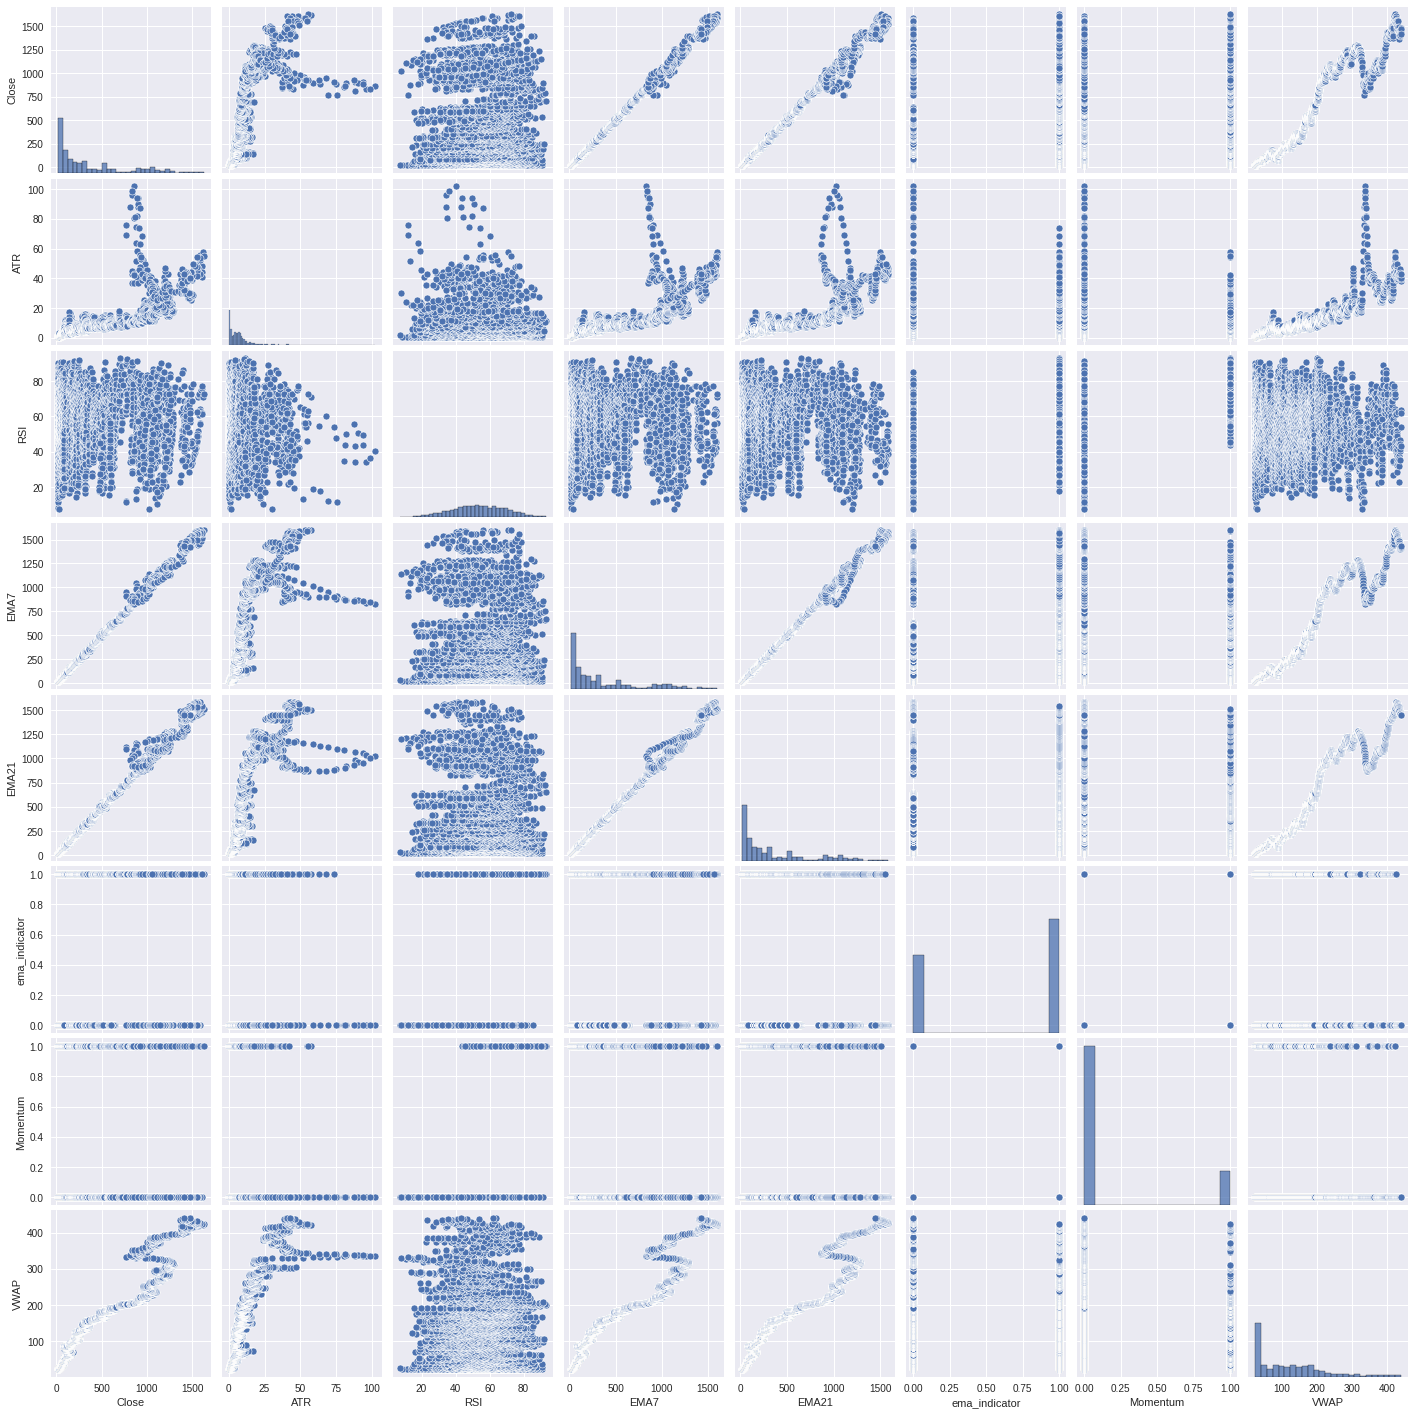

In [763]:
sns.pairplot(newdf[['Close','ATR','RSI','EMA7','EMA21','ema_indicator','Momentum','VWAP']])

Plotting of HeatMap to find correlation between the Features

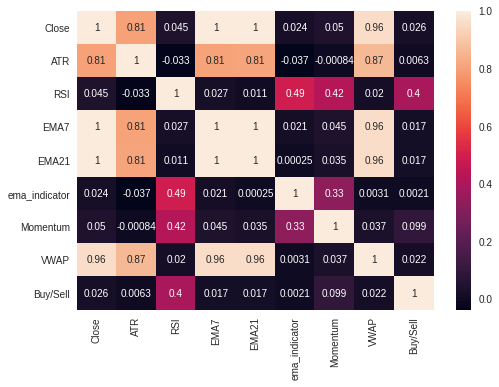

In [764]:
sns.heatmap(newdf[['Close','ATR','RSI','EMA7','EMA21','ema_indicator','Momentum','VWAP','Buy/Sell']].corr(), annot=True)

The strongest correlation that exists with the Target Variable "Buy/Sell" is RSI with a correlation coeffecient of 0.4

In [765]:
fig = go.Figure()
fig.add_trace(go.Scatter(x= newdf['Date'], y= newdf['Close'], fill='tozeroy', name= 'HDFC BANK'))
fig.update_layout(title = "Performance of HDFC")
fig.show()

Above graph is the equity curve of HDFC Bank

In [766]:
newdf

,level_0,Date,Open,High,Low,Close,Volume,ATR,RSI,RSI_CONDITION,EMA7,EMA21,ema_indicator,30days,15days,7days,Momentum,VWAP,percent_change,Buy/Sell
0,1,2000-03-16,26.200001,26.200001,25.504999,25.695000,1324640.0,2.124198,50.931600,0,26.526253,24.371188,1,12.064606,11.655960,-0.486476,0,26.138736,-0.011160,-1
1,2,2000-03-17,25.695000,25.695000,25.695000,25.695000,0.0,2.172778,50.931600,0,26.279310,24.354976,1,10.897059,11.655960,-5.876631,0,26.138736,0.000000,-1
2,3,2000-03-20,25.695000,25.695000,25.695000,25.695000,0.0,1.994835,50.931600,0,26.052109,24.399451,1,3.989102,11.441917,-4.923134,0,26.138736,0.000000,-1
3,4,2000-03-21,26.000000,26.000000,24.670000,25.580000,1601110.0,2.001886,49.586803,0,26.181188,24.493905,1,1.974195,15.246285,0.645031,0,25.977129,-0.004476,-1
4,5,2000-03-22,25.975000,26.500000,25.405001,26.115000,761300.0,1.976985,55.845059,0,25.961420,24.754667,1,3.312272,10.338881,-3.369715,0,25.993797,0.020915,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5267,5268,2021-04-26,1413.000000,1429.000000,1402.750000,1404.800049,15085476.0,40.387807,41.684352,0,1417.275425,1454.571623,0,-8.164860,-6.324742,0.316776,0,438.693218,-0.006612,-1
5268,5269,2021-04-27,1407.250000,1442.000000,1404.800049,1438.699951,10296453.0,38.387116,53.808892,0,1415.654898,1450.538749,0,-8.604994,-3.339824,0.597760,0,439.043661,0.024131,1
5269,5270,2021-04-28,1436.250000,1479.000000,1431.000000,1476.800049,12051970.0,39.801303,63.618228,0,1417.247187,1449.034561,0,-5.346015,1.841825,3.260429,0,439.469165,0.026482,1
5270,5271,2021-04-29,1486.199951,1503.650024,1461.000000,1472.500000,12039276.0,40.491163,61.906201,0,1423.055453,1448.553134,0,-5.395582,2.190153,4.081492,0,439.892111,-0.002912,-1


# Modelling

**Selecting the Features for input of the model**

In [767]:
X = newdf[[ 'RSI','ATR','ema_indicator','Momentum','VWAP','RSI_CONDITION']]

**Selecting the output as Buy/Sell**




In [768]:
y = newdf['Buy/Sell']

In [769]:
dataset_length = newdf.shape[0]

split = int(dataset_length * 0.75)
split

3954

Split is the training dataset length

In [770]:
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

We split the data into training set and validation set in 75:25 ratio

## We employ **XGBClassifier** as our model here


* Our fetaure set consists of both numerical and categorical features, we opt for decision based tree where nodes are split on categorical features (Reduces the size of Tree Built).


* A simple binary division tree is prone to overfitting and learning outcomes are highly dependent on training set due to which we explore Enesemble Methods to overcome the above pitfalls and shortcomings of a simple decision tree.



* We use ensemble method of XG boost that uses the concept of boosting to make multiple trees and uses gradient descent to reduce error/loss on trees being added, Thus reducing overfitting









In [771]:
model = XGBClassifier()

eval_set = [(X_train, y_train), (X_test, y_test)]

model.fit(X_train, y_train, eval_metric=['error', 'logloss'], eval_set=eval_set,verbose=True)

[0]	validation_0-error:0.308801	validation_0-logloss:0.675179	validation_1-error:0.308042	validation_1-logloss:0.675242
[1]	validation_0-error:0.308801	validation_0-logloss:0.659997	validation_1-error:0.308042	validation_1-logloss:0.660228
[2]	validation_0-error:0.308801	validation_0-logloss:0.647869	validation_1-error:0.308042	validation_1-logloss:0.648636
[3]	validation_0-error:0.308801	validation_0-logloss:0.637203	validation_1-error:0.308042	validation_1-logloss:0.638304
[4]	validation_0-error:0.30349	validation_0-logloss:0.628203	validation_1-error:0.312595	validation_1-logloss:0.62975
[5]	validation_0-error:0.302731	validation_0-logloss:0.62062	validation_1-error:0.311077	validation_1-logloss:0.623044
[6]	validation_0-error:0.30349	validation_0-logloss:0.61422	validation_1-error:0.312595	validation_1-logloss:0.616718
[7]	validation_0-error:0.302731	validation_0-logloss:0.608614	validation_1-error:0.311077	validation_1-logloss:0.611295
[8]	validation_0-error:0.30349	validation_0-l

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [772]:
pred = model.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 68.06%


The accuracy achieved is **68.06%** with the help of XGB Classifier


In [773]:
report = classification_report(y_test, model.predict(X_test))
print(report)

              precision    recall  f1-score   support

          -1       0.65      0.72      0.68       628
           1       0.72      0.64      0.68       690

    accuracy                           0.68      1318
   macro avg       0.68      0.68      0.68      1318
weighted avg       0.68      0.68      0.68      1318



Above is the f1 score

#**Report**:
The accuracy goes to say that 68% of the times the direction of the market was predicted right

# **Strategy**


* Since we have predicted the direction for tomorrow, what we can do is trade this in futures as BTST (Buy today Sell Tomorrow) or STBT (Sell today Buy Tomorrow).

* We assume to have sold or bought one lot of HDFC Bank at Yesterday's close and close the trade at today's market close


In [774]:
predictions_final = model.predict(X_test)

The above variable holds the predictions for the the last 25% of the data

In [775]:
predicted_df = newdf[split:]

We split the original dataframe to include only test data

In [776]:
predicted_df.head()

,level_0,Date,Open,High,Low,Close,Volume,ATR,RSI,RSI_CONDITION,EMA7,EMA21,ema_indicator,30days,15days,7days,Momentum,VWAP,percent_change,Buy/Sell
3954,3955,2015-12-23,536.299988,538.974976,534.575012,537.049988,1506984.0,8.063265,56.427573,0,534.895935,533.531790,1,-0.633093,-0.344481,1.773571,0,179.302870,0.007173,1
3955,3956,2015-12-24,538.099976,538.200012,534.150024,537.000000,1073176.0,7.612045,56.315792,0,536.430414,533.734524,1,0.856606,-0.256052,1.354753,0,179.321499,-0.000093,-1
3956,3957,2015-12-28,537.000000,539.950012,533.875000,538.625000,3877714.0,7.732946,59.337231,0,537.342696,534.008279,1,2.102578,1.703409,0.923644,1,179.389099,0.003026,1
3957,3958,2015-12-29,539.474976,539.924988,535.650024,538.974976,2115806.0,7.619384,60.024327,0,536.743775,533.696447,1,2.402700,1.484299,-0.213373,0,179.426009,0.000650,1
3958,3959,2015-12-30,540.000000,540.974976,536.275024,537.150024,1056280.0,7.683040,54.484978,0,536.841299,533.383327,1,1.242679,2.331755,0.121014,0,179.444339,-0.003386,-1


Now we shall append the predicted values to the new dataframe 

In [777]:
predicted_df['direction_predicted'] = predictions_final

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [778]:
predicted_df = predicted_df.reset_index()
predicted_df

,index,level_0,Date,Open,High,Low,Close,Volume,ATR,RSI,RSI_CONDITION,EMA7,EMA21,ema_indicator,30days,15days,7days,Momentum,VWAP,percent_change,Buy/Sell,direction_predicted
0,3954,3955,2015-12-23,536.299988,538.974976,534.575012,537.049988,1506984.0,8.063265,56.427573,0,534.895935,533.531790,1,-0.633093,-0.344481,1.773571,0,179.302870,0.007173,1,-1
1,3955,3956,2015-12-24,538.099976,538.200012,534.150024,537.000000,1073176.0,7.612045,56.315792,0,536.430414,533.734524,1,0.856606,-0.256052,1.354753,0,179.321499,-0.000093,-1,-1
2,3956,3957,2015-12-28,537.000000,539.950012,533.875000,538.625000,3877714.0,7.732946,59.337231,0,537.342696,534.008279,1,2.102578,1.703409,0.923644,1,179.389099,0.003026,1,-1
3,3957,3958,2015-12-29,539.474976,539.924988,535.650024,538.974976,2115806.0,7.619384,60.024327,0,536.743775,533.696447,1,2.402700,1.484299,-0.213373,0,179.426009,0.000650,1,-1
4,3958,3959,2015-12-30,540.000000,540.974976,536.275024,537.150024,1056280.0,7.683040,54.484978,0,536.841299,533.383327,1,1.242679,2.331755,0.121014,0,179.444339,-0.003386,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1313,5267,5268,2021-04-26,1413.000000,1429.000000,1402.750000,1404.800049,15085476.0,40.387807,41.684352,0,1417.275425,1454.571623,0,-8.164860,-6.324742,0.316776,0,438.693218,-0.006612,-1,-1
1314,5268,5269,2021-04-27,1407.250000,1442.000000,1404.800049,1438.699951,10296453.0,38.387116,53.808892,0,1415.654898,1450.538749,0,-8.604994,-3.339824,0.597760,0,439.043661,0.024131,1,1
1315,5269,5270,2021-04-28,1436.250000,1479.000000,1431.000000,1476.800049,12051970.0,39.801303,63.618228,0,1417.247187,1449.034561,0,-5.346015,1.841825,3.260429,0,439.469165,0.026482,1,1
1316,5270,5271,2021-04-29,1486.199951,1503.650024,1461.000000,1472.500000,12039276.0,40.491163,61.906201,0,1423.055453,1448.553134,0,-5.395582,2.190153,4.081492,0,439.892111,-0.002912,-1,1


## Now we will find out the number of captured points

* If the direction is +1 : We take a long position 
* If the direction is -1 : We take a short position



> Note : We buy/sell the stock at the day's closing price and close the position at tomorrow's close.



In [779]:
x = 1
points = []
while x < len(predicted_df['Date']):
  yc = predicted_df['Close'][x-1] #yc here refers to yesterday's closing price
  tc = predicted_df['Close'][x] #tc here refers to today's closing price
  direction = predicted_df['direction_predicted'][x]

  if (direction == +1):
    p = tc - yc
  elif (direction == -1):
    p = yc - tc
  
  points.append(p)
  x = x+1
  

In [780]:
predicted_df = predicted_df[1:] # we remove the first value because we cannot compute yesterdays close for that value

In [781]:
predicted_df = predicted_df.drop(columns=['index','level_0'])
predicted_df = predicted_df.reset_index()
predicted_df.head()

,index,Date,Open,High,Low,Close,Volume,ATR,RSI,RSI_CONDITION,EMA7,EMA21,ema_indicator,30days,15days,7days,Momentum,VWAP,percent_change,Buy/Sell,direction_predicted
0,1,2015-12-24,538.099976,538.200012,534.150024,537.000000,1073176.0,7.612045,56.315792,0,536.430414,533.734524,1,0.856606,-0.256052,1.354753,0,179.321499,-0.000093,-1,-1
1,2,2015-12-28,537.000000,539.950012,533.875000,538.625000,3877714.0,7.732946,59.337231,0,537.342696,534.008279,1,2.102578,1.703409,0.923644,1,179.389099,0.003026,1,-1
2,3,2015-12-29,539.474976,539.924988,535.650024,538.974976,2115806.0,7.619384,60.024327,0,536.743775,533.696447,1,2.402700,1.484299,-0.213373,0,179.426009,0.000650,1,-1
3,4,2015-12-30,540.000000,540.974976,536.275024,537.150024,1056280.0,7.683040,54.484978,0,536.841299,533.383327,1,1.242679,2.331755,0.121014,0,179.444339,-0.003386,-1,-1
4,5,2015-12-31,537.500000,542.450012,537.500000,541.075012,4645004.0,7.255118,62.966299,0,536.962367,532.955447,1,1.972922,3.206586,0.623758,0,179.525809,0.007307,1,1


We assign the captured points to the predicted_df in the name "points_captured"

In [782]:
predicted_df['points_captured'] = points

Considering the BankNifty Future lot size as 550; We shall calculate the profits

In [783]:
predicted_df['profit_per_lot'] = predicted_df['points_captured']*550

In [784]:
predicted_df.head()

,index,Date,Open,High,Low,Close,Volume,ATR,RSI,RSI_CONDITION,EMA7,EMA21,ema_indicator,30days,15days,7days,Momentum,VWAP,percent_change,Buy/Sell,direction_predicted,points_captured,profit_per_lot
0,1,2015-12-24,538.099976,538.200012,534.150024,537.000000,1073176.0,7.612045,56.315792,0,536.430414,533.734524,1,0.856606,-0.256052,1.354753,0,179.321499,-0.000093,-1,-1,0.049988,27.493286
1,2,2015-12-28,537.000000,539.950012,533.875000,538.625000,3877714.0,7.732946,59.337231,0,537.342696,534.008279,1,2.102578,1.703409,0.923644,1,179.389099,0.003026,1,-1,-1.625000,-893.750000
2,3,2015-12-29,539.474976,539.924988,535.650024,538.974976,2115806.0,7.619384,60.024327,0,536.743775,533.696447,1,2.402700,1.484299,-0.213373,0,179.426009,0.000650,1,-1,-0.349976,-192.486572
3,4,2015-12-30,540.000000,540.974976,536.275024,537.150024,1056280.0,7.683040,54.484978,0,536.841299,533.383327,1,1.242679,2.331755,0.121014,0,179.444339,-0.003386,-1,-1,1.824951,1003.723145
4,5,2015-12-31,537.500000,542.450012,537.500000,541.075012,4645004.0,7.255118,62.966299,0,536.962367,532.955447,1,1.972922,3.206586,0.623758,0,179.525809,0.007307,1,1,3.924988,2158.743286


We shall now calculate the portfolio equity

In [785]:
equity = []
sum = 0
for i in predicted_df['profit_per_lot']:
  sum = sum+i
  equity.append(sum)

Now we append the equity list to our predicted_df 

In [786]:
predicted_df['final_equity'] = equity

In [787]:
predicted_df

,index,Date,Open,High,Low,Close,Volume,ATR,RSI,RSI_CONDITION,EMA7,EMA21,ema_indicator,30days,15days,7days,Momentum,VWAP,percent_change,Buy/Sell,direction_predicted,points_captured,profit_per_lot,final_equity
0,1,2015-12-24,538.099976,538.200012,534.150024,537.000000,1073176.0,7.612045,56.315792,0,536.430414,533.734524,1,0.856606,-0.256052,1.354753,0,179.321499,-0.000093,-1,-1,0.049988,27.493286,2.749329e+01
1,2,2015-12-28,537.000000,539.950012,533.875000,538.625000,3877714.0,7.732946,59.337231,0,537.342696,534.008279,1,2.102578,1.703409,0.923644,1,179.389099,0.003026,1,-1,-1.625000,-893.750000,-8.662567e+02
2,3,2015-12-29,539.474976,539.924988,535.650024,538.974976,2115806.0,7.619384,60.024327,0,536.743775,533.696447,1,2.402700,1.484299,-0.213373,0,179.426009,0.000650,1,-1,-0.349976,-192.486572,-1.058743e+03
3,4,2015-12-30,540.000000,540.974976,536.275024,537.150024,1056280.0,7.683040,54.484978,0,536.841299,533.383327,1,1.242679,2.331755,0.121014,0,179.444339,-0.003386,-1,-1,1.824951,1003.723145,-5.502014e+01
4,5,2015-12-31,537.500000,542.450012,537.500000,541.075012,4645004.0,7.255118,62.966299,0,536.962367,532.955447,1,1.972922,3.206586,0.623758,0,179.525809,0.007307,1,1,3.924988,2158.743286,2.103723e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1312,1313,2021-04-26,1413.000000,1429.000000,1402.750000,1404.800049,15085476.0,40.387807,41.684352,0,1417.275425,1454.571623,0,-8.164860,-6.324742,0.316776,0,438.693218,-0.006612,-1,-1,9.349976,5142.486572,3.622135e+06
1313,1314,2021-04-27,1407.250000,1442.000000,1404.800049,1438.699951,10296453.0,38.387116,53.808892,0,1415.654898,1450.538749,0,-8.604994,-3.339824,0.597760,0,439.043661,0.024131,1,1,33.899902,18644.946289,3.640780e+06
1314,1315,2021-04-28,1436.250000,1479.000000,1431.000000,1476.800049,12051970.0,39.801303,63.618228,0,1417.247187,1449.034561,0,-5.346015,1.841825,3.260429,0,439.469165,0.026482,1,1,38.100098,20955.053711,3.661735e+06
1315,1316,2021-04-29,1486.199951,1503.650024,1461.000000,1472.500000,12039276.0,40.491163,61.906201,0,1423.055453,1448.553134,0,-5.395582,2.190153,4.081492,0,439.892111,-0.002912,-1,1,-4.300049,-2365.026855,3.659370e+06


##Final Profit 


> From 2016 to 2021



In [788]:
predicted_df['profit_per_lot'].sum()

3692480.1544189453

The final profit of this strategy is close to 37 lakhs in a period of 5 years without considering slippage and comissions

# Equity Graph of the Predictions

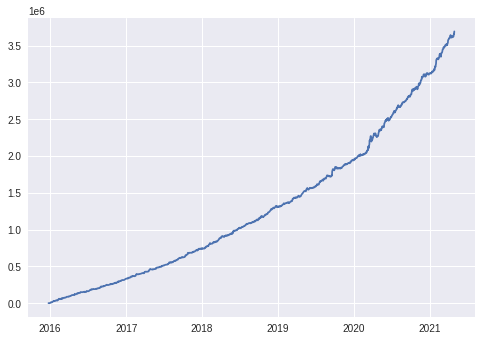

In [789]:
plt.plot(predicted_df['Date'],equity)

# **Final Report**
* To further increase the accuracy of the model we should add more features that has high degree of correlation with the target variable.
* With the help of Mutual Information we can select the best possible features during feature engineering